<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# CNN Text Classifier

by Fabian Märki

## Summary
The aim of this notebook is to build a CNN text classifier. It utilize pretrained word embeddings in order to take advantage of [transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning) in NLP. Additionally, it sets the stage for hyperparameter tuning and model design optimization.

## Links
- [Enabling GPU on Google Colab](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm)

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2022_HS_DAS_NLP_Notebooks/blob/master/04_a_CNN_Text_Classifier.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.4.8,<0.5.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.colab import runs_on_colab

import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.15.0-46-generic
Python version: 3.6.9
CPU cores: 6
RAM: 31.12GB total and 24.37GB available
Tensorflow version: 2.5.1
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


Download the [cleaned](https://github.com/markif/2022_FS_CAS_NLP_LAB_Notebooks/blob/master/02_a_Text_Cleaning.ipynb) and [preprocessed](https://github.com/markif/2022_FS_CAS_NLP_LAB_Notebooks/blob/master/02_b_Text_Normalization.ipynb) doctor reviews dataset. 

In [4]:
%%time
download("https://drive.google.com/uc?id=19AFeVnOfX8WXU4_3rM7OFoNTWWog_sb_", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 8.12 s, sys: 1.62 s, total: 9.75 s
Wall time: 5.36 s


Exclude *neutral* ratings so that the task becomes a binary classification.

In [5]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [6]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


Import some helper functions (later we will overwrite some functions in order to provide a better understanding of the process)...

In [7]:
from fhnw.nlp.utils.ploting import plot_history

from fhnw.nlp.utils.params import build_model_cnn
from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import re_compile_model
from fhnw.nlp.utils.params import save_model
from fhnw.nlp.utils.params import train_model

Setup the *params* dictionary which is used to specify hyperparameters and model design choices (and is also used to store intermediate results).  This sets the stage for a possible hyperparameter tuning and model design optimization (not part of this notebook).

In [8]:
params = {
    "verbose": True,
    "shuffle": True,
    # modify batch_size in case you experience memory issues
    "batch_size": 128,
    "X_column_name": "text_clean",
    "y_column_name": "label",
}

if runs_on_colab():
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.google.com/uc?id=1iqw8UPEEVmzQQGmI5FkRJH8B5SkZCgXG", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name

...extract the vocabulary...

In [9]:
create_label_binarizer_and_set(params, data)
extract_vocabulary_and_set(params, data)

Inferred classification type: binary
Median sequence length: 46
Percentil (0.98) cutoff sequence length: 230
Max sequence length: 408
Used embedding sequence length: 230


### Keras TextVectorization layer
Keras has a text preprocessing layer than can be placed before an embedding layer. The [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer accepts documents of various sizes. It pads sequences and tokenizes documents before they are passed to the embedding layer. At the embedding layer it can be used as an integer index (identifying the token/word) to access the embedding vectors.

In [10]:
def extract_text_vectorization_and_set(params):
    """Creates the TextVectorization layer and a vocabulary iterator and puts them into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    # see https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee
    try:
        # for newer tf versions use
        from tensorflow.keras.layers import TextVectorization
    except ImportError:
        from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

    verbose = params.get("verbose", False)
    output_sequence_length = params.get("output_sequence_length", None)
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vocabulary = params.setdefault(computed_objects_column_name, {})["vocabulary"]
    
    vectorize_layer = TextVectorization(
        output_mode='int',
        output_sequence_length=output_sequence_length,
        vocabulary=list(vocabulary),
        name="text_vectorization"
    )
    
    params.setdefault(computed_objects_column_name, {})["vocabulary_iterator"] = vectorize_layer.get_vocabulary()
    params.setdefault(computed_objects_column_name, {})["vectorize_layer"] = vectorize_layer

    if verbose:
        print("Vocabulary length:", vectorize_layer.vocabulary_size())

In [11]:
extract_text_vectorization_and_set(params)

Vocabulary length: 189790


Import and load fasttext word embeddings

In [ ]:
%%capture

!pip install fasttext

import fasttext
import fasttext.util
from fhnw.nlp.utils.colab import runs_on_colab

if runs_on_colab():
    from fhnw.nlp.utils.storage import download
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.google.com/uc?id=1iqw8UPEEVmzQQGmI5FkRJH8B5SkZCgXG", model_name)
else:
    model_name = "cc.de.300.bin"
    fasttext.util.download_model('de', if_exists='ignore')
    
ft = fasttext.load_model(model_name)

<font color='red'>**TASK: Implement `embed_word` using [fasttext](https://fasttext.cc/docs/en/unsupervised-tutorial.html#printing-word-vectors) function and provide the functionality as described in the function documentation.**</font>

You might get inspiration from: 
- [Pretrained Word Embeddings](https://towardsdatascience.com/pretrained-word-embeddings-using-spacy-and-keras-textvectorization-ef75ecd56360)

In [13]:
def embed_word(word):
    """Provides a word embedding

    Parameters
    ----------
    params: word
        The word to embed
    """
    
    # TODO: !!! place your code here !!!
    ####################################
    # !!! this needs rework !!!
    split = model_name.split(".")
    model_dim = int(split[2])
    return np.zeros(model_dim)

    ###################
    # TODO: !!! end !!!

In [14]:
embed_word("Haus")

array([-1.00356534e-01,  1.98468827e-02,  2.48073004e-02,  7.06050247e-02,
        1.98300742e-02, -3.88746560e-02, -4.34984528e-02,  4.89945710e-02,
        1.04627147e-01,  5.65351509e-02, -7.10811764e-02, -5.93297333e-02,
        4.17218879e-02,  3.44845019e-02,  1.02639869e-01, -1.89471599e-02,
        9.74735841e-02, -1.13834754e-01, -1.11242846e-01, -3.22935432e-02,
        7.66527653e-02, -8.67330432e-02,  4.17482406e-02, -7.92364925e-02,
       -5.29644429e-04,  2.38098130e-02,  4.14879844e-02,  6.87763914e-02,
       -1.07984124e-02, -3.47629637e-02, -4.95724231e-02,  3.55521441e-02,
       -1.52236251e-02,  1.78139266e-02,  4.51603755e-02,  6.61114156e-02,
        5.33561818e-02, -7.07296049e-03,  7.54112601e-02, -3.21409255e-02,
        5.20091765e-02, -2.71267351e-02,  3.36384997e-02, -8.52187872e-02,
        2.48614307e-02, -4.47589271e-02,  1.85794570e-02,  9.29193199e-02,
       -7.30394106e-03,  7.96798896e-03, -1.14537239e-01,  6.55219425e-03,
       -9.12078023e-02,  

### Transforming the Embedding Dictionary to an Embedding Layer
In order to use pre-trained embeddings in your model, you have to create a mapping from the word indices (provided by the TextVectorizer layer) to the word embedding vectors of the pre-trained embeddings. The embedding layer will use this index to look up the embedding, then pass the embeddings of each word in the input sequence to the next layer. 

Next, we will create and initialize the weights matrix for the embedding layer. The index position of each word in the vocabulary list (returned by TextVectorizer.get_vocabulary()) is the index that the TextVectorizer will return for each word. Thus we have to set the embedding vector for a word at this index.  We do this by looping over the words in the TextVectorizer vocabulary and the embedding dictionary. Each word encoding from the TextVectorizer will be the row index in the weights matrix and the vector accessed for that word will be the one from the embedding dictionary.

In [15]:
def calculate_embedding_matrix(params, embedder):
    """Creates the embedding matrix

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    embedder: function
        The function to get the embedding for a word
    """    
    
    import numpy as np

    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vocabulary_iterator = params.setdefault(computed_objects_column_name, {})["vocabulary_iterator"]
    tmp_embedding = embedder("haus")
    
    if (tmp_embedding is not None) and len(tmp_embedding) > 0:
        embedding_dim = len(tmp_embedding)
    else:
        embedding_dim = params["embedding_dim"]
    voc_size = len(vocabulary_iterator)
    words_not_found = set()
    embedding_matrix = np.zeros((voc_size, embedding_dim))

    for idx, word in enumerate(vocabulary_iterator):
        embedding_vector = embedder(word)
        if (embedding_vector is not None) and len(embedding_vector) > 0 and not np.all(embedding_vector==0):
            # words not found in embedding index will be all-zeros.
            embedding_matrix[idx] = embedding_vector
        else:
            words_not_found.add(word)

    if params["verbose"]:
        print("Embedding type:", params.get("embedding_type"))
        print("Number of null word embeddings:", np.sum(np.sum(embedding_matrix, axis=1) == 0))
        nr_words_not_found = len(words_not_found)
        print("Words not found in total:", len(words_not_found))
        if nr_words_not_found > 0:
            import random
            
            nr_sample = min(20, len(words_not_found))
            print("Words without embedding (", nr_sample, "/", nr_words_not_found, "): ", random.sample(words_not_found, nr_sample), sep='')
    
    return embedding_matrix


def extract_embedding_layer_and_set(params):
    """Creates the Embedding layer and puts it into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    import tensorflow as tf
    from tensorflow import keras
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
          
    embedding_matrix = calculate_embedding_matrix(params, embed_word)       
    embedding_layer = keras.layers.Embedding(
                                          embedding_matrix.shape[0], 
                                          embedding_matrix.shape[1], 
                                          weights=[embedding_matrix],
                                          input_length=params["embedding_input_sequence_length"],
                                          trainable=params.get("embedding_trainable", False),
                                          mask_zero = params.get("embedding_mask_zero", True),
                                          name="embedding"
                                         )
        
    params.setdefault(computed_objects_column_name, {})["embedding_layer"] = embedding_layer

In [16]:
%%time

extract_embedding_layer_and_set(params)

Embedding type: None
Number of null word embeddings: 9
Words not found in total: 9
Words without embedding (9/9): ['ìn', 'äk', 'èn', 'üw', '', 'úm', 'jé', 'öä', 'öz']
CPU times: user 3.71 s, sys: 189 ms, total: 3.9 s
Wall time: 3.9 s


...some words (without embedding) suggest that there still exist corrupt text...

In [17]:
data[data["text_clean"].str.contains(' úm ')]

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
3264,Heute war ich zum ersten Mal gemeinsam mit mei...,1.0,Heute war ich zum ersten Mal gemeinsam mit mei...,positive,1,"[heute, war, ich, zum, ersten, mal, gemeinsam,...",heute war ich zum ersten mal gemeinsam mit mei...,"[heute, erst, mal, gemeinsam, jährig, tochter,...","[heut, erst, mal, gemeinsam, jahrig, tocht, pr...","[heute, ersten, mal, gemeinsam, jährigen, toch..."


... seems to be ok...

...prepare the training/test/validation data...

In [18]:
data_train, data_test = get_train_test_split(params, data)
data_train, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

264949 train examples
66238 test examples
211959 train examples
52990 test examples


In [19]:
for text, labels in dataset_train.take(1):
    print(text)
    print(labels)

{'text_clean': <tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'k\xc3\xbcrzlich zum ersten mal bei frau dr link gewesen zur vorsorge . war positiv \xc3\xbcberrascht sympathische und kompetente \xc3\xa4rztin . hat mich sehr geduldig und verst\xc3\xa4ndnisvoll beraten und gr\xc3\xbcndlich untersucht . auch das personal war sehr freundlich und professionell . gute praxisorganisation , kaum wartezeit .',
       b'wurde jeder zeit weiterempfehlen',
       b'dr. frenken nimmt sich au\xc3\x9fergew\xc3\xb6hnlich viel zeit f\xc3\xbcr seine patienten . er h\xc3\xb6rt aufmerksam zu , gleicht befunde mit daten aus fr\xc3\xbcheren jahren ab und geht insgesamt sehr sorgf\xc3\xa4ltig und gewissenhaft vor , um die richtige diagnose zu stellen . dabei erkl\xc3\xa4rt und ber\xc3\xa4t er ausf\xc3\xbchrlich und geduldig . wenn es notwendig ist , kann man ihn auch au\xc3\x9ferhalb der praxiszeiten erreichen . die atmosph\xc3\xa4re in der praxis ist so , dass man sich wirklich gut aufgehoben f\xc3\xb

Umlaute seem to have strange encoding - let's test first to be sure

In [20]:
tensor = tf.constant(u"ärzte für 😊 unbekanntes_wort später")
vec = params["computed_objects"]["vectorize_layer"]

print(tensor)
print(vec(tensor))

tf.Tensor(b'\xc3\xa4rzte f\xc3\xbcr \xf0\x9f\x98\x8a unbekanntes_wort sp\xc3\xa4ter', shape=(), dtype=string)
tf.Tensor([ 66973 107913      1      1 123240], shape=(5,), dtype=int64)


Seems to be able to map the words correctly to meaningfull indices (except unknown words/signs).

Some more helper function (overwrite them here in order to make the process clearer)...

In [21]:
def get_loss_function(params):
    """Decides upon the loss function to use based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
        
    Returns
    -------
    str
        The name of the loss function (or a callable)
    """
        
    classification_type = params.get("classification_type", "binary")
    
    if classification_type == "binary":
        model_loss_function = "binary_crossentropy"
    elif classification_type == "multi-class":
        model_loss_function = "categorical_crossentropy"
    elif classification_type == "multi-label":
        model_loss_function = "binary_crossentropy"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    return model_loss_function


def get_model_metric(params):
    """Provides the metric based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
        
    Returns
    -------
    list
        The list of metrics to use
    """
    
    return params.get("model_metric", ["accuracy"])


def compile_model(params, model):
    """Compiles the model based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    """
    
    from tensorflow import keras
        
    optimizer_learning_rate = params.get("learning_rate", 0.01)
    optimizer_learning_rate_decay = params.get("optimizer_learning_rate_decay", None)
    model_metric = get_model_metric(params)
    model_loss_function = get_loss_function(params)

    adam = keras.optimizers.Adam(learning_rate=optimizer_learning_rate)
    if optimizer_learning_rate_decay is not None:
        adam = keras.optimizers.Adam(learning_rate=optimizer_learning_rate, decay=optimizer_learning_rate_decay)

    model.compile(loss=model_loss_function, optimizer=adam, metrics=model_metric)
    
    
def re_compile_model(params, model):
    """Re-compiles the model based on the provided params and the existing optimizer 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    """
    
    from tensorflow import keras
    
    # use a low learning rate for fine tuning
    optimizer_learning_rate = params.get("learning_rate", 1e-5)
    model_metric = get_model_metric(params)
    model_loss_function = get_loss_function(params)
    
    # keep existing internal parameters for further runs
    optimizer = model.optimizer
    optimizer.learning_rate.assign(optimizer_learning_rate)

    model.compile(loss=model_loss_function, optimizer=optimizer, metrics=model_metric)


def train_model(params, model, dataset_train, dataset_val):
    """Performs the model training 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    dataset_train: tf Dataset
        The dataset for training
    dataset_val; tf Dataset
        The dataset for validation
        
    Returns
    -------
    history
        The training history
    """
        
    import os
    import datetime
    from tensorflow import keras

    training_epochs = params.get("training_epochs", 5)
    training_logdir = params.get("training_logdir", None)
    
    if training_logdir is None:
        training_logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    #tensorboard_callback = keras.callbacks.TensorBoard(training_logdir, histogram_freq=1)

    history = model.fit(
        dataset_train,
        validation_data=dataset_val,
        #callbacks=[tensorboard_callback],
        epochs=training_epochs)
    
    return history

<font color='red'>**TASK: Improve the CNN model defined in `build_model_cnn` (play with filter size, kernel size, activation function, model design etc...)**</font>

You might get inspiration from:
- [Conv1D with Global Max Pooling](https://colab.research.google.com/drive/1RvCnR7h0_l4Ekn5vINWToI9TNJdpUZB3#scrollTo=fAnI0YwfvXdG)
- [Multichannel CNN Model for Text Classification](https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/)

In [22]:
def build_model_cnn_simple(params):
    """Builds a simple cnn classifier (only partially) based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
        
    from tensorflow import keras
    
    # choose the output activation function based on the classification type
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    X_column_name = params.get("X_column_name", "text_clean")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    
    model = keras.Sequential(name="cnn")
    # A text input layer
    model.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name=X_column_name))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model.add(embedding_layer)
    
    
    # build the CNN 
    cnn_conv_num_filters = 128
    cnn_conv_kernel_size = 7
    model.add(keras.layers.Conv1D(
        cnn_conv_num_filters, 
        cnn_conv_kernel_size, 
        activation="relu", 
        strides=1, 
        padding="valid", # valid -> no padding, same -> zeros so that output has same dimensions
        name="conv_1"))
    # add global max pooling
    model.add(keras.layers.GlobalMaxPooling1D(name="global_max_pool_1"))

    # do not forget Dropout (regularization) for a more sophisticated model
    
    # add the classification head
    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    return model

**Note: The run you see below is from a build_model_cnn(...) model (i.e. your output might look different)!**

In [23]:
model = build_model_cnn(params)
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         56937000  
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 128)         268928    
_________________________________________________________________
global_max_pool_1 (GlobalMax (None, 128)               0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 129       
Total params: 57,206,057
Trainable params: 269,057
Non-trainable params: 56,937,000
_________________________________________________________________


In [24]:
compile_model(params, model)

In [25]:
params["training_epochs"] = 10
history = train_model(params, model, dataset_train, dataset_val)

Epoch 1/10
1656/1656 [==============================] - 58s 33ms/step - loss: 0.1205 - accuracy: 0.9520 - val_loss: 0.0893 - val_accuracy: 0.9661
Epoch 2/10
1656/1656 [==============================] - 39s 23ms/step - loss: 0.0803 - accuracy: 0.9691 - val_loss: 0.0888 - val_accuracy: 0.9673
Epoch 3/10
1656/1656 [==============================] - 39s 23ms/step - loss: 0.0696 - accuracy: 0.9737 - val_loss: 0.0798 - val_accuracy: 0.9706
Epoch 4/10
1656/1656 [==============================] - 38s 23ms/step - loss: 0.0616 - accuracy: 0.9769 - val_loss: 0.0846 - val_accuracy: 0.9700
Epoch 5/10
1656/1656 [==============================] - 38s 23ms/step - loss: 0.0560 - accuracy: 0.9788 - val_loss: 0.0835 - val_accuracy: 0.9707
Epoch 6/10
1656/1656 [==============================] - 39s 23ms/step - loss: 0.0493 - accuracy: 0.9820 - val_loss: 0.0851 - val_accuracy: 0.9709
Epoch 7/10
1656/1656 [==============================] - 38s 23ms/step - loss: 0.0454 - accuracy: 0.9835 - val_loss: 0.0926 -

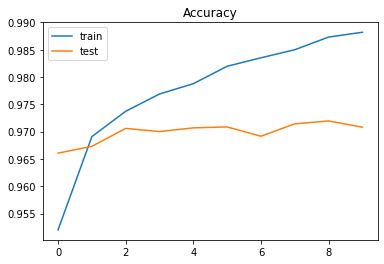

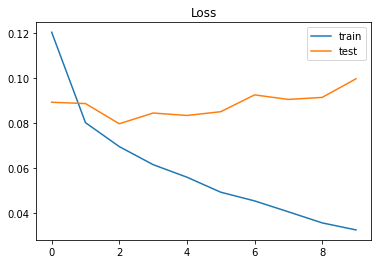

In [26]:
plot_history(history)

Quite overfitted. Training could stop after ~3 epochs and some regularizations (like dropout) could also make sense.  

Let's see if it is possible to further improve the model by unfreezing the embedding layer.

Also see https://www.tensorflow.org/guide/keras/transfer_learning

In [27]:
# Unfreeze all layers (i.e. make embeddings trainable)
model.trainable = True
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         56937000  
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 128)         268928    
_________________________________________________________________
global_max_pool_1 (GlobalMax (None, 128)               0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 129       
Total params: 57,206,057
Trainable params: 57,206,057
Non-trainable params: 0
_________________________________________________________________


In [28]:
re_compile_model(params, model)

In [29]:
params["training_epochs"] = 2
history = train_model(params, model, dataset_train, dataset_val)

Epoch 1/2
1656/1656 [==============================] - 716s 432ms/step - loss: 0.0212 - accuracy: 0.9930 - val_loss: 0.0944 - val_accuracy: 0.9734
Epoch 2/2
1656/1656 [==============================] - 718s 433ms/step - loss: 0.0147 - accuracy: 0.9958 - val_loss: 0.0937 - val_accuracy: 0.9734


In [31]:
from fhnw.nlp.utils.ploting import report_classification_results

Check performance on all data.

Set Population: 331187
Accuracy: 0.9884


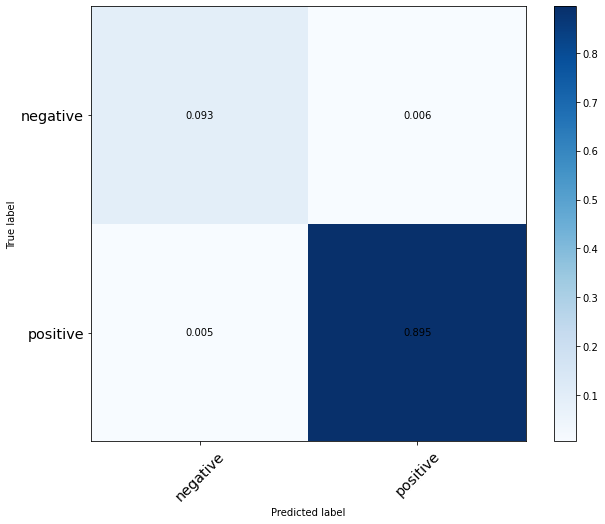

              precision    recall  f1-score   support

    negative       0.95      0.94      0.94     33022
    positive       0.99      0.99      0.99    298165

    accuracy                           0.99    331187
   macro avg       0.97      0.97      0.97    331187
weighted avg       0.99      0.99      0.99    331187

CPU times: user 1min 55s, sys: 790 ms, total: 1min 55s
Wall time: 49.7 s


In [32]:
%%time

report_classification_results(params, data, model)

Check performance on test data.

Set Population: 66238
Accuracy: 0.9728


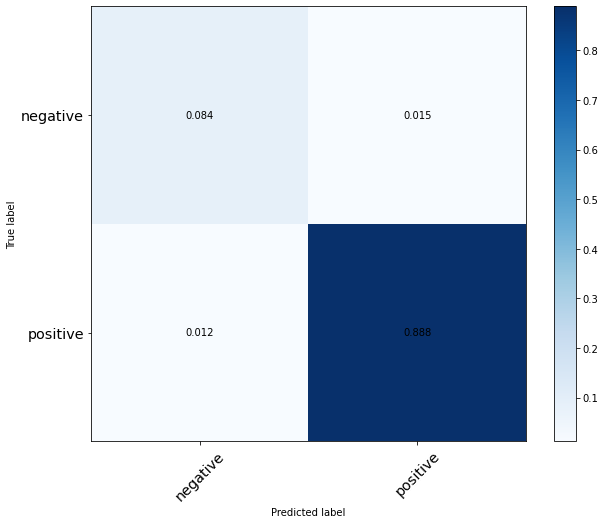

              precision    recall  f1-score   support

    negative       0.88      0.85      0.86      6604
    positive       0.98      0.99      0.98     59634

    accuracy                           0.97     66238
   macro avg       0.93      0.92      0.92     66238
weighted avg       0.97      0.97      0.97     66238

CPU times: user 20.7 s, sys: 107 ms, total: 20.8 s
Wall time: 7.89 s


In [33]:
%%time

report_classification_results(params, data_test, model)